# Dogs vs Cats (TF 2.1.5 -Softmax)
**End to End Image Classification project using TensorFlow**

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cat_dog.gif" width="750" align="center">

In [1]:
import tensorflow as tf
tf.__version__

'2.17.0'

In [2]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Flatten,Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

## Organize data OLD SCHOOL!

In [3]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip --qq cats_and_dogs_filtered.zip

--2024-09-14 16:59:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  41.4MB/s    in 1.6s    

2024-09-14 16:59:48 (41.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
!pip install split_folders

## Splitting folders
We will split the input in 3 different dataset: train, val, test

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/splitting_folder.png" width="450" align="center">

In [5]:
import splitfolders
input_folder = 'cats_and_dogs_filtered/train/'
output_folder = 'data/'

In [6]:
splitfolders.ratio(input_folder,output_folder,seed=667,ratio=(.6,.2,.2))

Copying files: 2000 files [00:00, 4630.36 files/s]


In [7]:
img_height, img_width = (150,150)
batch_size = 10

train_data_dir = 'data/train'
validation_data_dir = 'data/val'
test_data_dir = 'data/test'

## NEW WAY TF2.1.5 (all classes divided inside subfolders)

In [8]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dogs_cats_all.zip
!unzip --qq dogs_cats_all.zip

--2024-09-14 17:00:00--  https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/dogs_cats_all.zip
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 3.5.246.126, 3.5.245.26, 52.95.144.6, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|3.5.246.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68391667 (65M) [application/octet-stream]
Saving to: ‘dogs_cats_all.zip’

dogs_cats_all.zip   100%[===================>]  65.22M  16.8MB/s    in 3.9s    

2024-09-14 17:00:05 (16.8 MB/s) - ‘dogs_cats_all.zip’ saved [68391667/68391667]




<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/augmentation.png" width="800" align="center">

In [20]:
dataset = 'dogs_cats_all'

image_size = (150, 150)
batch_size = 32
ch=3

In [21]:
train_generator = image_dataset_from_directory(dataset,
                                                validation_split=0.2,
                                                subset="training",
                                                seed=667,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                label_mode = 'categorical'
                                                )

validation_generator = image_dataset_from_directory(dataset,
                                                validation_split=0.2,
                                                subset="validation",
                                                seed=667,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                label_mode = 'categorical'
                                                )

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [22]:
class_names = train_generator.class_names
class_names

['cats', 'dogs']

In [23]:
num_classes = len(class_names)
num_classes

2

In [24]:
model = Sequential()

#Convolution Layer1
model.add(Conv2D(64, (3, 3), input_shape=(150, 150, 3),activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
#Convolution Layer2
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
#Convolution Layer3
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

#Flattening
model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

#output with 2 neurons, so we can apply softmax
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      21,233,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,605,250 (82.42 MB)

 Trainable params: 21,605,250 (82.42 MB)

 Non-trainable params: 0 (0.00 B)

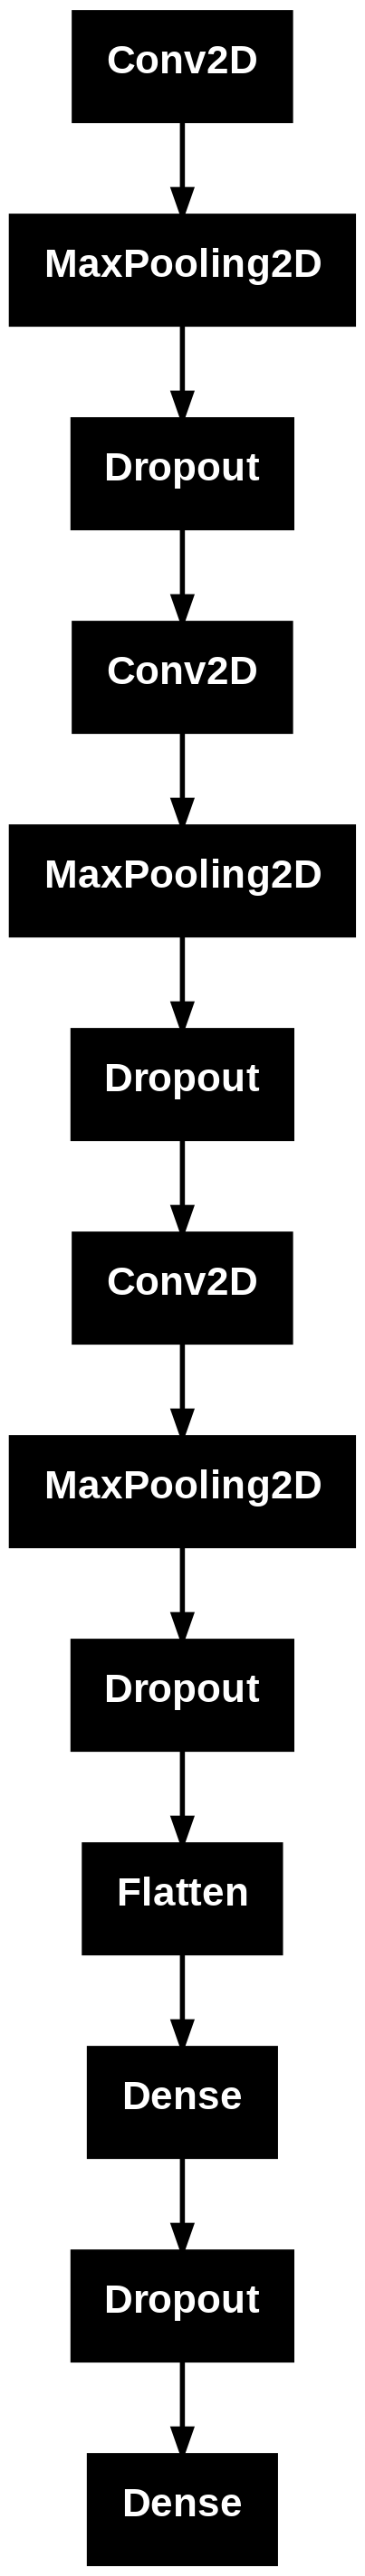

In [26]:
plot_model(model)

In [27]:
file_path="weights_best.keras"# from TF2.17
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    #steps_per_epoch=len(train_generator),
                    #validation_steps=len(validation_generator),
                    callbacks=callbacks_list,
                    verbose=2
                    )

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to weights_best.keras
75/75 - 12s - 164ms/step - accuracy: 0.5150 - loss: 31939.7109 - val_accuracy: 0.4917 - val_loss: 0.6932
Epoch 2/10

Epoch 2: val_accuracy improved from 0.49167 to 0.50833, saving model to weights_best.keras
75/75 - 12s - 156ms/step - accuracy: 0.5192 - loss: 1.1460 - val_accuracy: 0.5083 - val_loss: 0.6993
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.50833
75/75 - 13s - 176ms/step - accuracy: 0.4842 - loss: 0.7302 - val_accuracy: 0.4917 - val_loss: 0.6951
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.50833
75/75 - 5s - 64ms/step - accuracy: 0.4825 - loss: 0.6993 - val_accuracy: 0.4917 - val_loss: 0.7007
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.50833
75/75 - 5s - 61ms/step - accuracy: 0.4933 - loss: 0.6968 - val_accuracy: 0.5083 - val_loss: 0.6930
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.50833
75/75 - 7s - 89ms/step - accuracy: 0.483

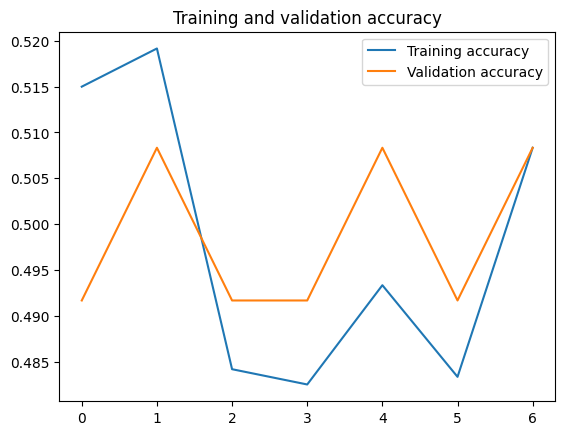

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

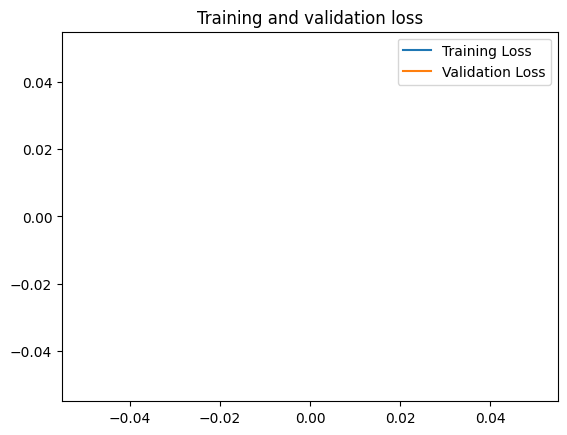

In [19]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [29]:
# Struttura della nostra Neural Network
model =Sequential()

model.add(Conv2D(32, (3,3), input_shape=(150, 150, 3),activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

# Output layer - Number neuron == number classes
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,634 (13.17 MB)

 Trainable params: 3,453,634 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
file_path="weights_best.keras"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early] #early

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    #steps_per_epoch=len(train_generator),
                    #validation_steps=len(validation_generator),
                    callbacks=callbacks_list,
                    verbose=2
                    )

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.55500, saving model to weights_best.keras
75/75 - 21s - 283ms/step - accuracy: 0.5067 - loss: 4.1684 - val_accuracy: 0.5550 - val_loss: 0.7971
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.55500
75/75 - 5s - 71ms/step - accuracy: 0.5646 - loss: 0.7659 - val_accuracy: 0.5533 - val_loss: 0.7098
Epoch 3/10

Epoch 3: val_accuracy improved from 0.55500 to 0.57500, saving model to weights_best.keras
75/75 - 7s - 89ms/step - accuracy: 0.6275 - loss: 0.6643 - val_accuracy: 0.5750 - val_loss: 0.6856
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.57500
75/75 - 3s - 46ms/step - accuracy: 0.6592 - loss: 0.6286 - val_accuracy: 0.5733 - val_loss: 0.6953
Epoch 5/10

Epoch 5: val_accuracy improved from 0.57500 to 0.57833, saving model to weights_best.keras
75/75 - 3s - 42ms/step - accuracy: 0.6762 - loss: 0.5884 - val_accuracy: 0.5783 - val_loss: 0.6969
Epoch 6/10

Epoch 6: val_accuracy improved from 0.57833 to 0.61167, sav

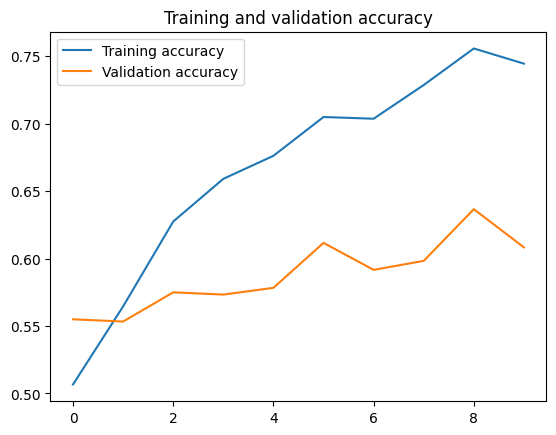

In [32]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

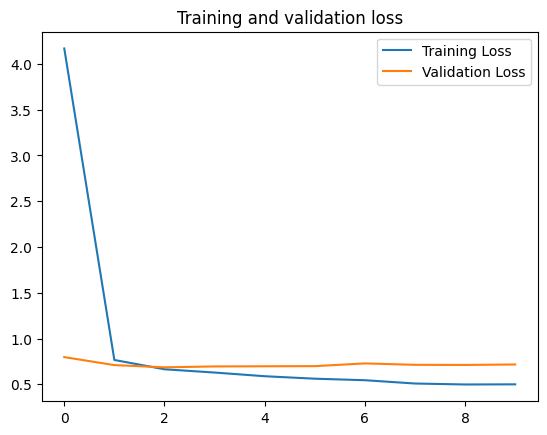

In [33]:
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [34]:
model.save('dog_cat_finetuned.h5')

In [35]:
model = load_model('dog_cat_finetuned.h5')

In [37]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in validation_generator:
    prediction_classes = np.concatenate([prediction_classes,np.argmax(model.predict(x), axis = -1)])
    true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


## Print first 50 observation

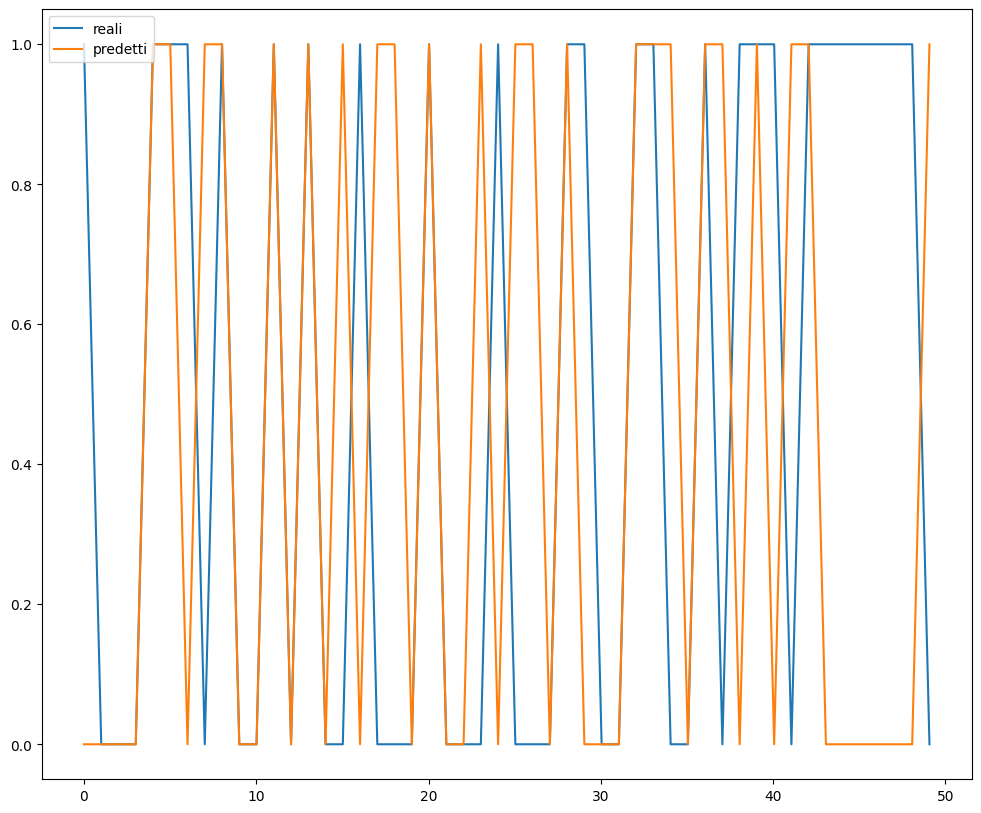

In [38]:
length = prediction_classes.shape[0] # 30
x = np.linspace(0,length,length)

plt.figure(figsize=(12,10))
plt.plot(x[:50], true_classes[:50], label='reali')
plt.plot(x[:50], prediction_classes[:50], label='predetti')
plt.legend(loc=2);

In [39]:
print(classification_report(true_classes, prediction_classes))

              precision    recall  f1-score   support

         0.0       0.62      0.59      0.61       305
         1.0       0.60      0.63      0.61       295

    accuracy                           0.61       600
   macro avg       0.61      0.61      0.61       600
weighted avg       0.61      0.61      0.61       600



# Confusion Matrix

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/cf_dog.jpg" width="800" align="center">

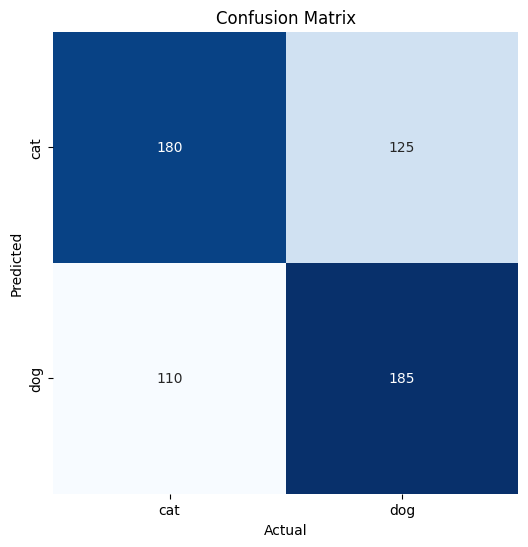

In [40]:
cm = pd.crosstab(true_classes,prediction_classes,
                 rownames = ['Predicted'],
                 colnames = ['Actual'])

plt.figure(figsize=(6,6))
plt.title('Confusion Matrix')
labels = ['cat','dog']
sns.heatmap(cm,xticklabels=labels,yticklabels=labels,cmap='Blues',annot=True,fmt='g',cbar=False);

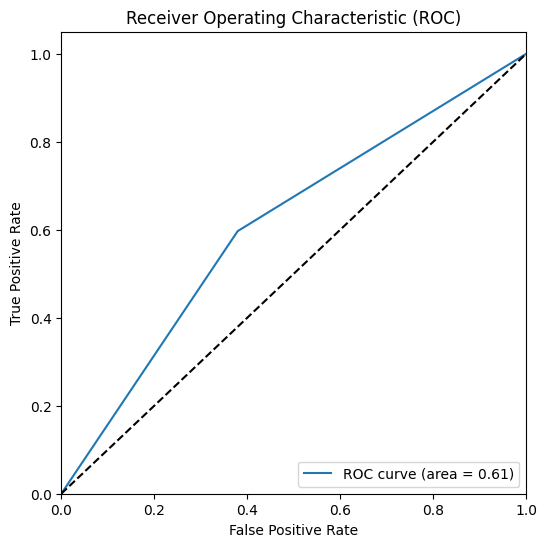

In [42]:
from sklearn.metrics import roc_curve, auc
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(true_classes,prediction_classes)

## Testing with New Data

In [ ]:
#{'cats': 0, 'dogs': 1}

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yolo.jpg to yolo.jpg


In [43]:
import numpy as np
from tensorflow.keras.preprocessing import image

classes = {0:"cat",
           1:"dog",}

# predicting images
path = 'dog.jpg'
#resize to the right input format
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
pred = model.predict(images)
print(pred)
pred = np.argmax(pred, axis=-1)[0]  ## Finalmente con la softmax!
res = classes[pred]
print("class= "+str(pred),", it's a:",res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step
[[7.5791928e-04 9.9924207e-01]]
class= 1 , it's a: dog


## Convert tflite

In [44]:
import tensorflow as tf
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open('my_model.tflite', "wb").write(tfmodel)

Saved artifact at '/tmp/tmpgam_z3zd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  140191477279104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477282800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477326144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477330016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477450704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477452992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477457216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477459504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477665632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140191477668448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1401914776654

13819156